# Import libraries

In [1]:

# load basic libraries
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib
# vizualisation library
import seaborn as sns
# add simple stat methods
from statistics import mean, stdev
import statsmodels.stats.multitest as multitest
from math import sqrt
# sklearn tools
#from sklearn.preprocessing import Imputer
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
# import stats
from scipy import stats
# umap 
import umap


/home/tom/anaconda2/envs/hivscc/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
# Number of repetitions of classifiers to run and average
# n=1000 used in paper, changed to smaller value here for a reasonable runtime
# note that numbers will differ slightly from manuscript for this reason
n_repeats = 10

# Help functions

In [3]:
# box plot for 2 different values

def box_stripe_plot(feature_1,feature_2,label_1,label_2,title):
    
    # make a dataframe
    my_data = pd.DataFrame({label_1: pd.Series(feature_1), label_2: pd.Series(feature_2)})
    my_data.head()

    sns.boxplot(data = my_data.loc[:,:],palette="Set2",fliersize=0)
    sns.stripplot(data = my_data.loc[:,:],jitter=True,palette="Set2", dodge=True,linewidth=1,edgecolor='gray')
    plt.ylabel('Feature units')
    plt.title(title)


In [4]:
# function to create the random forest classifier and plot the results

def random_forest_plot(input_data, labels, name, feature_names, num_classes, use_resampling=False):
    
    # number of features to show
    features_to_show=5
    
    # data
    data=input_data[:,:]

    # labels
    data_labels=labels
    
    # encode the labels
    le = preprocessing.LabelEncoder()
    le.fit(data_labels)
    data_labels=le.transform(data_labels)
    
    # test data
    X, y = input_data, data_labels
    
    # resample the data
    # fix sampling algorithm random state
#     if use_resampling == True:
#         try:
#             ros = RandomUnderSampler(random_state=0)
            
#             X, y = ros.fit_resample(X, y)
#             print('Data is resampled using undersampling')
#         except(ValueError):
#             print('Resampling is not used')
    
    # first split with stratification
    try:
        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y)
        n_unique=len(np.unique(y_test))
    except(ValueError):
        
    # when stratification does not work
            x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
            print('Could not stratify classes')
            n_unique=len(np.unique(y_train))
            while n_unique >= num_classes:
                # do the random split
                x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
                n_unique=len(np.unique(y_train))
                if n_unique >= num_classes:
                    print('Number of classes in the training set:' +str(n_unique))
                    break
                    
    # data augmentation        
    
    #features
    n_features=np.shape(data)[1]

    # create the right classifier
    clf = RandomForestClassifier(bootstrap=True, class_weight='balanced', criterion='gini',
                max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                min_impurity_decrease=0.0, min_impurity_split=None,
                min_samples_leaf=2, min_samples_split=2,
                min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=1,
                oob_score=True, random_state=0, verbose=0)
    
    #RandomForestClassifier(max_depth=None, random_state=0)
    clf.fit(x_train, y_train)
    
    data_labels_predict=clf.predict(x_test)
    
    # get the scores of the trees and pring them
    random_forest_precision = precision_score(y_test, data_labels_predict,average='micro')
    random_forest_f1 = f1_score(y_test, data_labels_predict,average='micro')
    print ('Random forest precision: ' +str(random_forest_precision))
    print ('Random forest f1 score: ' +str(random_forest_f1)) 
    feature_importance=clf.feature_importances_
    
    # fix the seed for shuffled dataset
    np.random.seed=42
    
    # create radom labels
    data_labels_shuffle=np.random.randint(len(np.unique(data_labels_predict)), size=len(data_labels_predict))
    # create shuffled labels
#    data_labels_shuffle=data_labels_predict
#    np.random.shuffle(data_labels_shuffle)
    
    random_forest_precision_random=precision_score(y_test, data_labels_shuffle,average='micro')
    print ('Random forest random labels performance: ' + str(random_forest_precision_random))
    
    print()
    
    # compute and plot the feature order
    feature_order_idx=np.flip(np.argsort(feature_importance),0)

#    print ('Random forest, important features:')
#    for i in range(features_to_show):
#        print(feature_names[feature_order_idx[i]])
#        
#    print()

    labels_names=np.unique(le.inverse_transform(y_test))

    # plot the confusion matrix
    fig, ax = plt.subplots()
    conf_matrix = confusion_matrix(y_test, data_labels_predict)
    # normalise confusion matrix
    conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    labels_names_form=[]
    # make label names shorter
    for i in range(len(labels_names)):
        # make the cell type name shorter
        labels_names[i]=labels_names[i][10:]
        # create the list with the cell type names
        labels_names_form.append(labels_names[i])
    # compute confusion matrix
    try:
        conf_matrix_pd=pd.DataFrame(conf_matrix, index=labels_names_form, columns=labels_names_form)
    except(ValueError):
        print('Not all classes are present in the testing set')
        conf_matrix_pd=pd.DataFrame(conf_matrix)
    sns.set(font_scale=1.4)
    ax = sns.heatmap(conf_matrix_pd,annot=False,annot_kws={"size": 16},vmin=0, vmax=1)
    num_classes = len(labels_names)
    ax.set_title('Random forest e-type to cluster-type: ' + str(num_classes) + ' classes')
    ax.set_xlabel('True label')
    ax.set_ylabel('Predicted label')
    
    # return the classifier precision
    return random_forest_precision, random_forest_precision_random


In [5]:

def impute_no_nan(all_features_matrix,nan_thr=10):

    n_nan=np.zeros(len(all_features_matrix))

    for i in np.arange(len(all_features_matrix)):
        # count the number of nans
        n_nan[i] = len(np.argwhere(np.isnan(all_features_matrix[i,:])))

    # set up a threshold for the nan numbers
    all_features_matrix_no_nan=all_features_matrix[np.where(n_nan<nan_thr)[0]]
    
    # impute all NaNs in the array and replace with the median
    imp = Imputer(missing_values=np.nan, strategy='median', axis=0)
    imp.fit(all_features_matrix_no_nan)

    all_features_new=imp.transform(all_features_matrix_no_nan)
    
    return all_features_new


# Import ephys and data labels

In [6]:
from pathlib import Path
ephys_path = Path('../data/human_mouse_ephys_all_0127.csv')
mouse_cells_path = Path("../data/mouse_IVSCC_excitatory_L23_consolidated_0129.csv")
human_cells_path = Path("../data/human_IVSCC_excitatory_L23_consolidated_0131.csv")
mouse_morph_path = Path("../data/All_Mouse_Cells_Lockdown_All_raw_features.csv")
human_morph_path = Path("../data/All_L23_Lockdown_all_raw_features.csv")

In [7]:

# human and mouse ephys data
ephys_human_mouse = pd.read_csv(ephys_path)
ephys_human_mouse=ephys_human_mouse.dropna(axis=0)

# human labels
data_human = pd.read_csv(human_cells_path)
# filter to take only 3 cell types
human_types=['Exc L2-3 LINC00507 FREM3','Exc L2 LAMP5 LTK','Exc L2-4 LINC00507 GLP2R']
data_human=data_human.loc[data_human['SeuratMapping'].isin(human_types)]

# mouse labels
data_mouse = pd.read_csv(mouse_cells_path)
mouse_types=['L2/3 IT VISp Rrad','L2/3 IT VISp Agmat','L2/3 IT VISp Adamts2']
data_mouse=data_mouse.loc[data_mouse['SeuratMapping'].isin(mouse_types)]


## Prepare the training data

In [8]:

# feature list
feature_list = ephys_human_mouse.keys().values
feature_list=feature_list[1:]

# cell IDs
human_ids = data_human['SpecimenID'].values
mouse_ids = data_mouse['SpecimenID'].values

# form the datasets and sort them
ephys_human = ephys_human_mouse.loc[ephys_human_mouse['specimen_id'].isin(human_ids)]
ephys_human = ephys_human.sort_values(by=['specimen_id'])
ephys_mouse = ephys_human_mouse.loc[ephys_human_mouse['specimen_id'].isin(mouse_ids)]
ephys_mouse = ephys_mouse.sort_values(by=['specimen_id'])

# get the dataset
ephys_human_array = ephys_human.values
ephys_human_array = ephys_human_array[:,1:]
ephys_mouse_array = ephys_mouse.values
ephys_mouse_array = ephys_mouse_array[:,1:]

# impute values and normalize the datasets
imputer = KNNImputer(n_neighbors=5)
ephys_human_array=imputer.fit_transform(ephys_human_array)
ephys_mouse_array=imputer.fit_transform(ephys_mouse_array)

# scale the datasets
scaler = StandardScaler()
scaler.fit(ephys_human_array)
ephys_human_array=scaler.transform(ephys_human_array)
scaler.fit(ephys_mouse_array)
ephys_mouse_array=scaler.transform(ephys_mouse_array)


# get back the IDs
human_ids = ephys_human['specimen_id'].values
mouse_ids = ephys_mouse['specimen_id'].values

# get the labels
human_labels = data_human.loc[data_human['SpecimenID'].isin(human_ids)]['SeuratMapping'].values
mouse_labels = data_mouse.loc[data_mouse['SpecimenID'].isin(mouse_ids)]['SeuratMapping'].values



## Compare cell features one by one: FREM3, GLP2R, LTK vs. RRAD, AGMAT, ADAMTS2

### Pairwise feature comparison

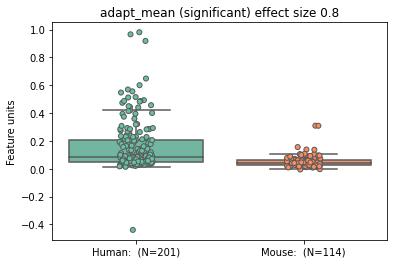

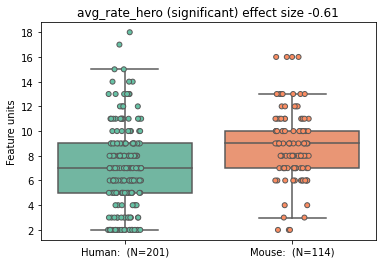

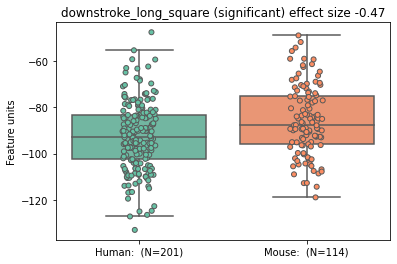

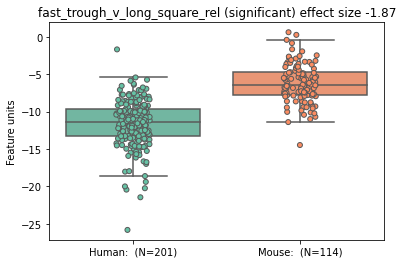

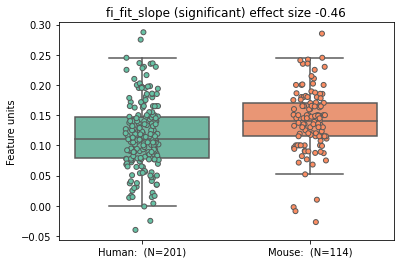

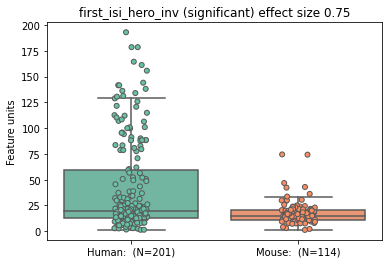

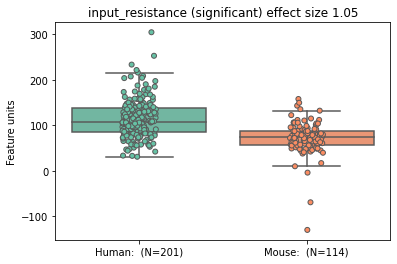

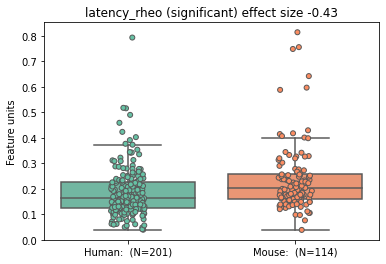

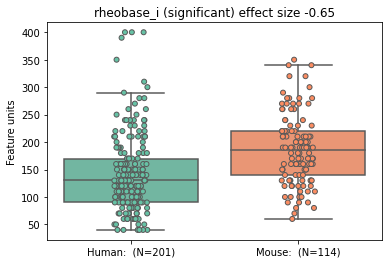

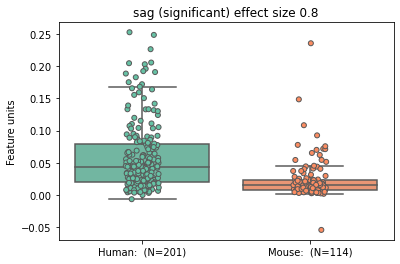

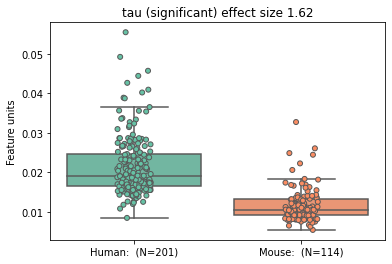

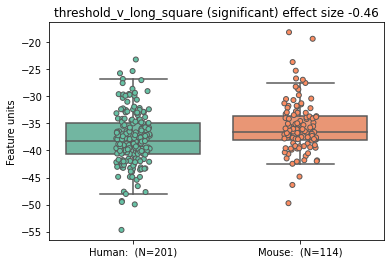

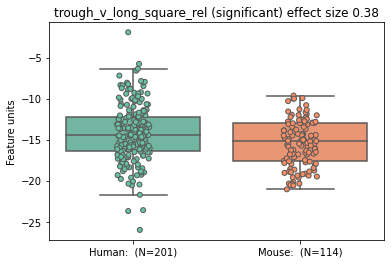

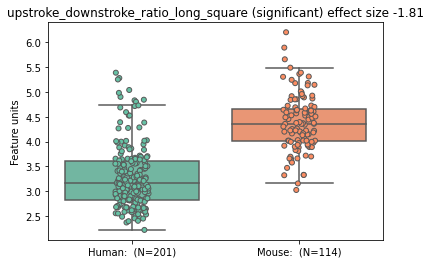

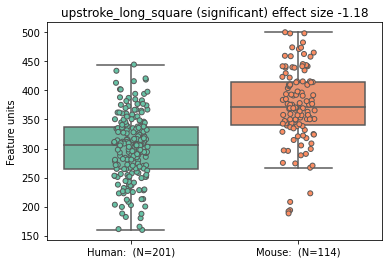

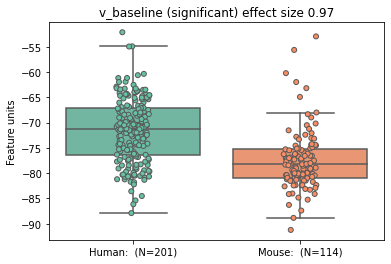

In [9]:

# list of features to compare
feature_names=ephys_human.keys()[1:]
n_features=len(feature_names)

# counter for significant features
n_sign_features=0

# significance level
alpha_level=0.05

# lists for results
p_values=np.ones(len(feature_names))
d_values=np.ones(len(feature_names))
cohens_d=[]
n_sign_features=0

# loop to compute p-values
for i in range(len(feature_names)):
    
    # compute corresponding features from dataframes                        
    feature_1=ephys_human[feature_names[i]].values
    feature_2=ephys_mouse[feature_names[i]].values
    
    # do not take NaNs
    feature_1 = feature_1[~np.isnan(feature_1)]
    feature_2 = feature_2[~np.isnan(feature_2)]

    # convert arrays to lists
    feature_1=feature_1.tolist()
    feature_2=feature_2.tolist()

    if feature_1:
        if feature_2:
            
                # p-values is computed by mann whitheney test
                d,p=stats.mannwhitneyu(feature_1,feature_2)
                # record the p_values
                p_values[i]=p
                d_values[i]=d
                
                # labels for features
                labels=['Human: ' + ' (N='+str(len(feature_1)) +')','Mouse: ' + ' (N='+str(len(feature_2)) +')']
                
                # compute the effect size
                if mean(feature_1) > mean(feature_2):
                    cohens_d.append(np.abs((mean(feature_1) - mean(feature_2)) / (sqrt((stdev(feature_1) ** 2 + stdev(feature_2) ** 2) / 2))))
                else:
                    cohens_d.append(-np.abs((mean(feature_1) - mean(feature_2)) / (sqrt((stdev(feature_1) ** 2 + stdev(feature_2) ** 2) / 2))))


                # Bonferoni correction
                if p<=float(alpha_level/n_features):
                    
                    n_sign_features=n_sign_features+1
                    fig, ax = plt.subplots()


                    if p<=float(alpha_level/n_features):
                        title = feature_names[i] +str(' (significant)') +str(' effect size ') +str(np.round(cohens_d[-1],2))
                    else:
                        title = feature_names[i] +str(' (non-significant)') +str(' effect size ') +str(np.round(cohens_d[-1],2))

                    box_stripe_plot(feature_1,feature_2,labels[0],labels[1],title)


# do the FDR features correction
p_values_bool,p_values_fdr=multitest.fdrcorrection(p_values,alpha=0.05)


### Show the effect size (Cohen's d)

In [10]:

for i in range(len(feature_names)):
    print(str(feature_names[i]) + ' ' + str(cohens_d[i]))
    

adapt_mean 0.796135799805418
avg_rate_hero -0.6084278156118433
downstroke_long_square -0.47059743447561075
fast_trough_v_long_square_rel -1.8683066790650182
fi_fit_slope -0.45974588146579987
first_isi_hero_inv 0.7499789200351801
input_resistance 1.052451948805636
latency_rheo -0.42944197546000323
peak_v_long_square_rel 0.26301369786542533
rheobase_i -0.6464339108625117
sag 0.7954859831181672
tau 1.6237023074702353
threshold_v_long_square -0.45612164959890145
trough_v_long_square_rel 0.37590136925097906
upstroke_downstroke_ratio_long_square -1.8111648724581058
upstroke_long_square -1.179495457833698
v_baseline 0.9662106817302165
width_long_square 0.10548610711520286


### Show the FDR corrected p-values

In [11]:

for i in range(len(feature_names)):
    print(str(feature_names[i]) + ' ' + str(p_values_fdr[i]))


adapt_mean 4.59895733187163e-15
avg_rate_hero 6.6776981884287045e-09
downstroke_long_square 0.00011602308558641786
fast_trough_v_long_square_rel 6.394700393144553e-35
fi_fit_slope 1.1952180922747065e-05
first_isi_hero_inv 3.497324107321577e-05
input_resistance 1.8643845712853976e-17
latency_rheo 3.497324107321577e-05
peak_v_long_square_rel 0.0032833517263650496
rheobase_i 1.5318110791925902e-09
sag 9.672155899857335e-14
tau 5.747993103497467e-35
threshold_v_long_square 4.075297476065853e-05
trough_v_long_square_rel 0.002467593417818923
upstroke_downstroke_ratio_long_square 3.232554293688348e-31
upstroke_long_square 1.2677064026654299e-19
v_baseline 9.114589436468527e-16
width_long_square 0.08376027316966012


### Show the summary of different features

In [12]:

print ('Bonferroni: ' + str(n_sign_features) + ' out of ' + str(n_features) + str(' features are different'))


Bonferroni: 16 out of 18 features are different


## Train the classifiers for different cell types

### Human data

Random forest precision: 0.6065573770491803
Random forest f1 score: 0.6065573770491803
Random forest random labels performance: 0.3114754098360656



(0.6065573770491803, 0.3114754098360656)

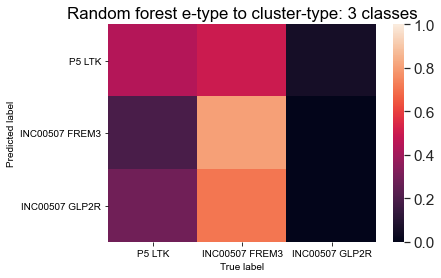

In [13]:

num_class = len(np.unique(human_labels))
random_forest_plot(ephys_human_array, human_labels, 'Human', feature_list, num_class, use_resampling=False)
#plt.savefig('Human_3_classes.pdf',format='pdf')


Random forest precision: 0.6229508196721312
Random forest f1 score: 0.6229508196721312
Random forest random labels performance: 0.4918032786885246

Random forest precision: 0.6721311475409836
Random forest f1 score: 0.6721311475409836
Random forest random labels performance: 0.4918032786885246

Random forest precision: 0.6557377049180327
Random forest f1 score: 0.6557377049180327
Random forest random labels performance: 0.45901639344262296

Random forest precision: 0.639344262295082
Random forest f1 score: 0.639344262295082
Random forest random labels performance: 0.3442622950819672

Random forest precision: 0.6721311475409836
Random forest f1 score: 0.6721311475409836
Random forest random labels performance: 0.3442622950819672

Random forest precision: 0.6557377049180327
Random forest f1 score: 0.6557377049180327
Random forest random labels performance: 0.3114754098360656

Random forest precision: 0.6557377049180327
Random forest f1 score: 0.6557377049180327
Random forest random label

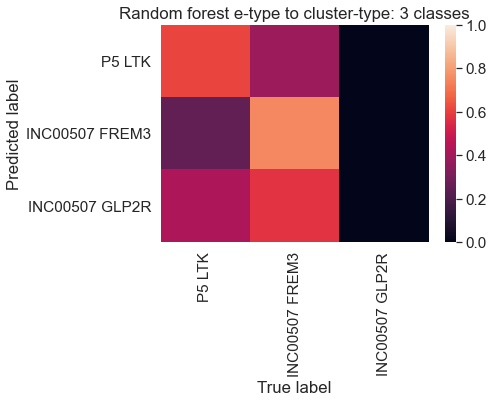

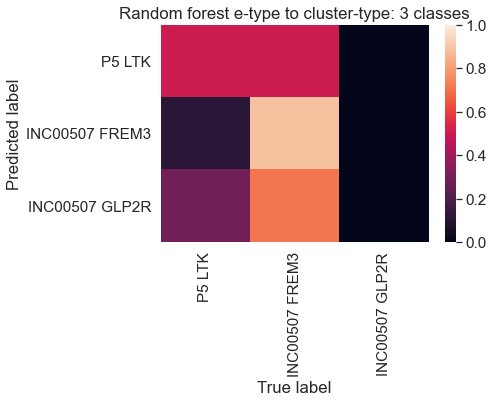

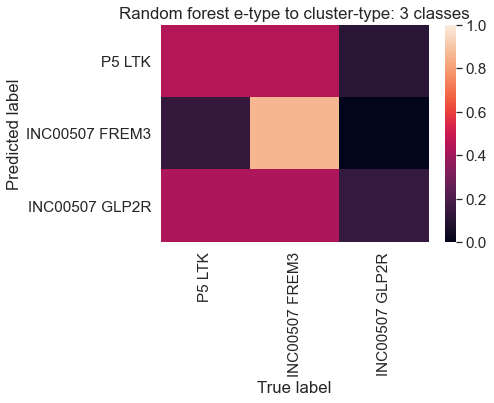

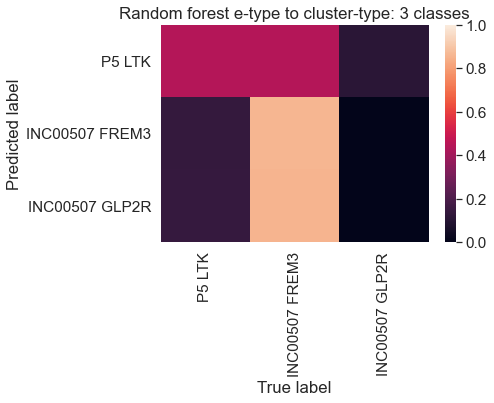

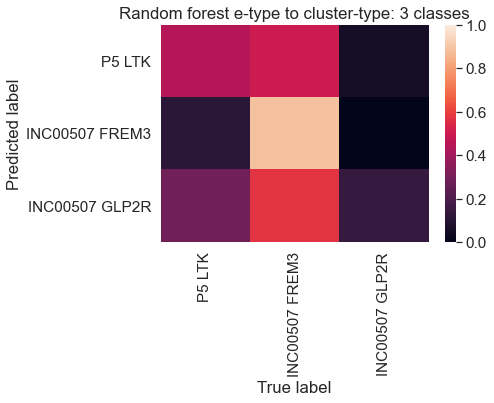

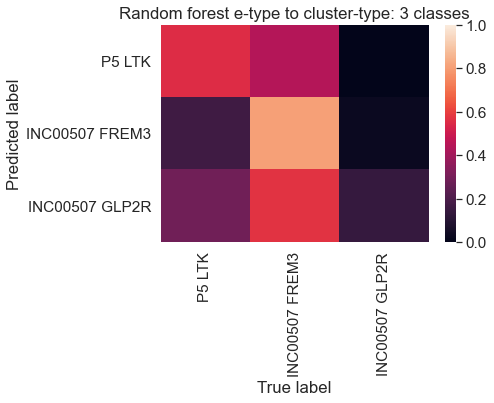

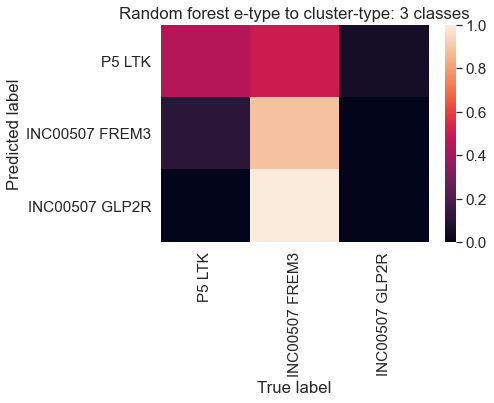

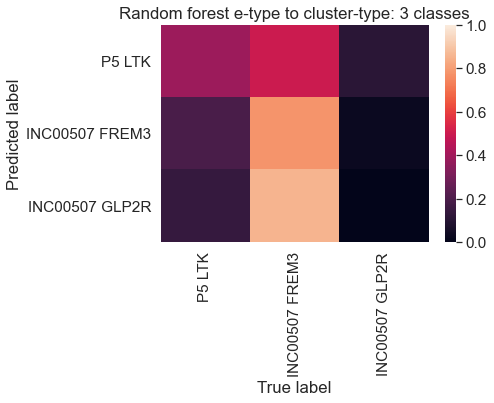

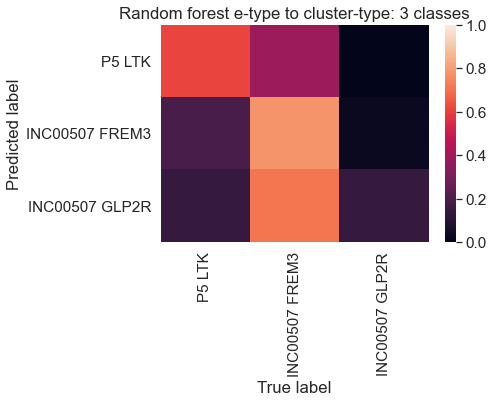

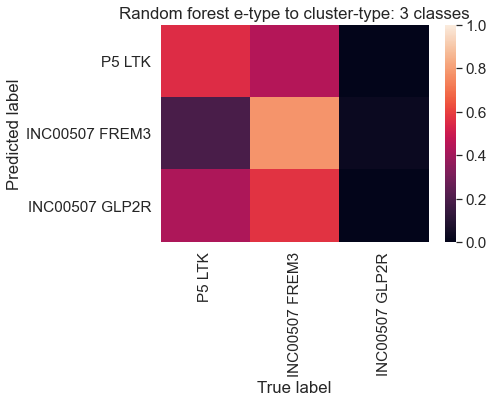

In [14]:
# run random forest multiple times

prec_all=[]
rand_all=[]

for j in range(n_repeats):
    prec ,rand =random_forest_plot(ephys_human_array, human_labels, 'Human', feature_list, num_class, use_resampling=False)
    prec_all.append(prec)
    rand_all.append(rand)

print('Classifier precision: ' + str(np.mean(prec_all)))
print('Random precision: ' + str(np.mean(rand_all)))


In [15]:

print('Human ephys')
print('Classifier precision: ' + str(np.mean(prec_all)))
print('Random precision: ' + str(np.mean(rand_all)))


Human ephys
Classifier precision: 0.6426229508196721
Random precision: 0.3918032786885246


## Mouse data

Random forest precision: 0.6571428571428571
Random forest f1 score: 0.6571428571428571
Random forest random labels performance: 0.37142857142857144



(0.6571428571428571, 0.37142857142857144)

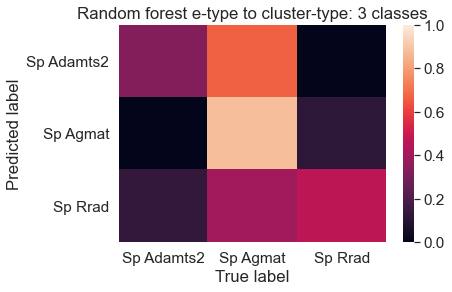

In [16]:

num_class = len(np.unique(mouse_labels))
random_forest_plot(ephys_mouse_array, mouse_labels, 'Mouse', feature_list, num_class, use_resampling=False)
#plt.savefig('Mouse_3_classes.pdf',format='pdf')


Random forest precision: 0.5714285714285714
Random forest f1 score: 0.5714285714285714
Random forest random labels performance: 0.2

Random forest precision: 0.5142857142857142
Random forest f1 score: 0.5142857142857142
Random forest random labels performance: 0.2857142857142857

Random forest precision: 0.6
Random forest f1 score: 0.6
Random forest random labels performance: 0.5714285714285714

Random forest precision: 0.6857142857142857
Random forest f1 score: 0.6857142857142857
Random forest random labels performance: 0.2

Random forest precision: 0.45714285714285713
Random forest f1 score: 0.45714285714285713
Random forest random labels performance: 0.45714285714285713

Random forest precision: 0.6285714285714286
Random forest f1 score: 0.6285714285714286
Random forest random labels performance: 0.2857142857142857

Random forest precision: 0.6571428571428571
Random forest f1 score: 0.6571428571428571
Random forest random labels performance: 0.3142857142857143

Random forest precisi

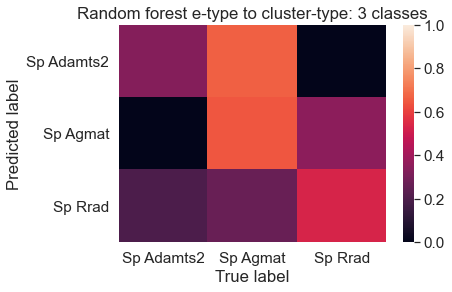

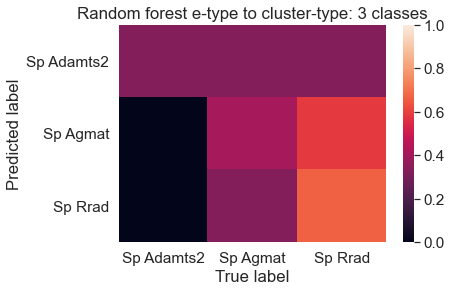

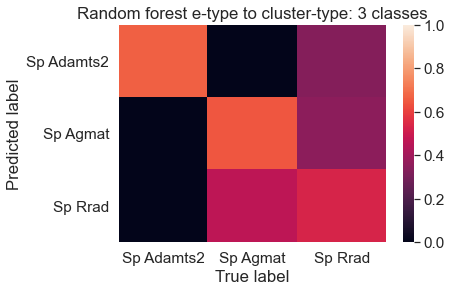

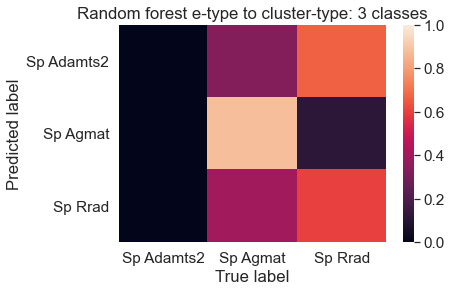

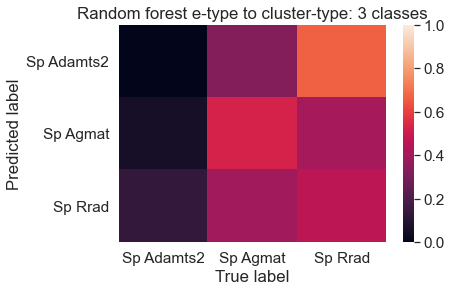

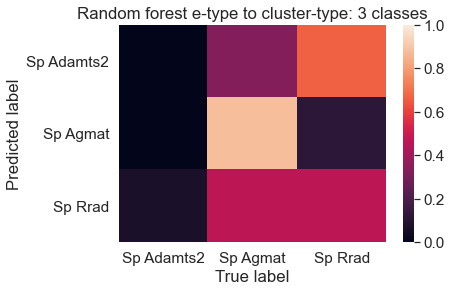

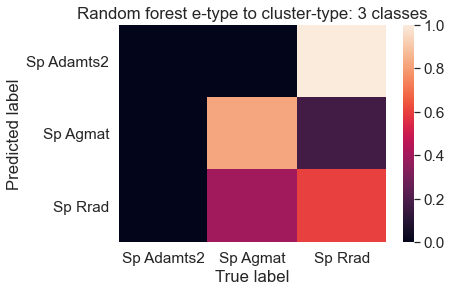

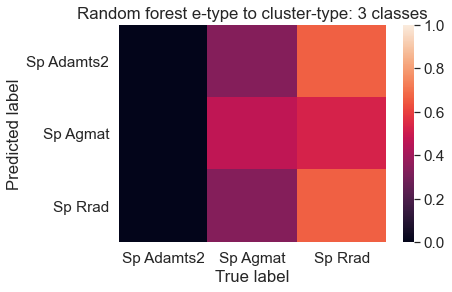

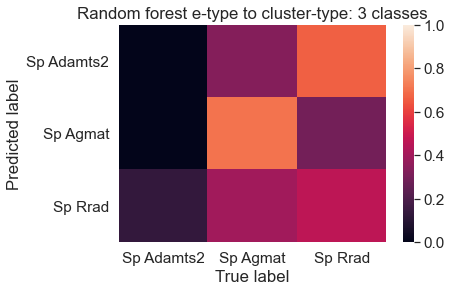

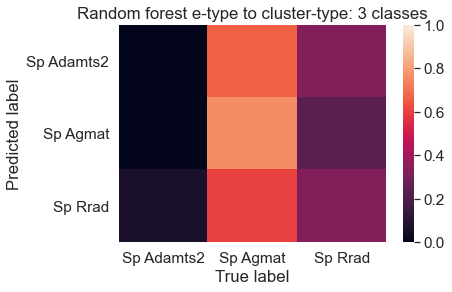

In [17]:
# run random forest multiple times

prec_all=[]
rand_all=[]

for j in range(n_repeats):
    prec ,rand = random_forest_plot(ephys_mouse_array, mouse_labels, 'Mouse', feature_list, num_class, use_resampling=False)
    prec_all.append(prec)
    rand_all.append(rand)

print('Classifier precision: ' + str(np.mean(prec_all)))
print('Random precision: ' + str(np.mean(rand_all)))


In [18]:

print('Mouse ephys')
print('Classifier precision: ' + str(np.mean(prec_all)))
print('Random precision: ' + str(np.mean(rand_all)))


Mouse ephys
Classifier precision: 0.5685714285714285
Random precision: 0.34285714285714286


# Morpho features classifier

## Prepare the data

In [19]:

# human labels
data_human = pd.read_csv(human_cells_path)
# filter to take only 3 cell types
human_types=['Exc L2-3 LINC00507 FREM3','Exc L2 LAMP5 LTK','Exc L2-4 LINC00507 GLP2R']
data_human=data_human.loc[data_human['SeuratMapping'].isin(human_types)]

# mouse labels
data_mouse = pd.read_csv(mouse_cells_path)
mouse_types=['L2/3 IT VISp Rrad','L2/3 IT VISp Agmat','L2/3 IT VISp Adamts2']
data_mouse=data_mouse.loc[data_mouse['SeuratMapping'].isin(mouse_types)]


In [20]:

# human features
human_morpho=pd.read_csv(human_morph_path)
human_morpho_names = human_morpho.keys()[1:]

# mouse features
mouse_morpho=pd.read_csv(mouse_morph_path)
mouse_morpho_names = mouse_morpho.keys()[1:]

feature_list=np.intersect1d(human_morpho_names,mouse_morpho_names)


In [21]:

# cell IDs
human_ids = data_human['SpecimenID'].values
mouse_ids = data_mouse['SpecimenID'].values

# form the datasets and sort them
human_morpho = human_morpho.loc[human_morpho['specimen_id'].isin(human_ids)]
human_morpho = human_morpho.sort_values(by=['specimen_id'])
mouse_morpho = mouse_morpho.loc[mouse_morpho['specimen_id'].isin(mouse_ids)]
mouse_morpho = mouse_morpho.sort_values(by=['specimen_id'])

# morpho array
human_morpho_array = human_morpho.values[:,1:]
mouse_morpho_array = mouse_morpho.values[:,1:]

# impute values and normalize the datasets
imputer = KNNImputer(n_neighbors=5)
human_morpho_array=imputer.fit_transform(human_morpho_array)
mouse_morpho_array=imputer.fit_transform(mouse_morpho_array)

# scale the data
scaler = StandardScaler()
scaler.fit(human_morpho_array)
human_morpho_array=scaler.transform(human_morpho_array)
scaler.fit(mouse_morpho_array)
mouse_morpho_array=scaler.transform(mouse_morpho_array)


In [22]:

# get back the IDs
human_ids = human_morpho['specimen_id'].values
mouse_ids = mouse_morpho['specimen_id'].values

# get the labels
human_labels = data_human.loc[data_human['SpecimenID'].isin(human_ids)]['SeuratMapping'].values
mouse_labels = data_mouse.loc[data_mouse['SpecimenID'].isin(mouse_ids)]['SeuratMapping'].values


## Human morpho data classifier

Random forest precision: 0.6896551724137931
Random forest f1 score: 0.6896551724137931
Random forest random labels performance: 0.3448275862068966



(0.6896551724137931, 0.3448275862068966)

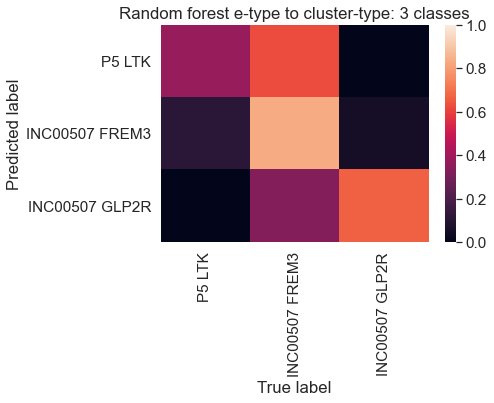

In [23]:

num_class = len(np.unique(human_labels))
random_forest_plot(human_morpho_array, human_labels, 'Human', feature_list, num_class, use_resampling=False)
#plt.savefig('Human_morpho_3.pdf',format='pdf')


Random forest precision: 0.7931034482758621
Random forest f1 score: 0.7931034482758621
Random forest random labels performance: 0.3103448275862069

Random forest precision: 0.5862068965517241
Random forest f1 score: 0.5862068965517241
Random forest random labels performance: 0.3103448275862069

Random forest precision: 0.6551724137931034
Random forest f1 score: 0.6551724137931034
Random forest random labels performance: 0.20689655172413793

Random forest precision: 0.6206896551724138
Random forest f1 score: 0.6206896551724138
Random forest random labels performance: 0.3448275862068966

Random forest precision: 0.6206896551724138
Random forest f1 score: 0.6206896551724138
Random forest random labels performance: 0.2413793103448276

Random forest precision: 0.5172413793103449
Random forest f1 score: 0.5172413793103449
Random forest random labels performance: 0.41379310344827586

Random forest precision: 0.6206896551724138
Random forest f1 score: 0.6206896551724138
Random forest random la

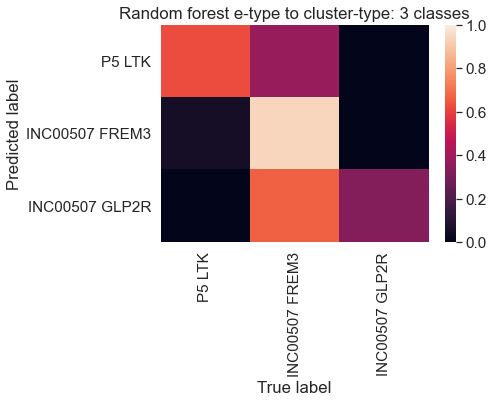

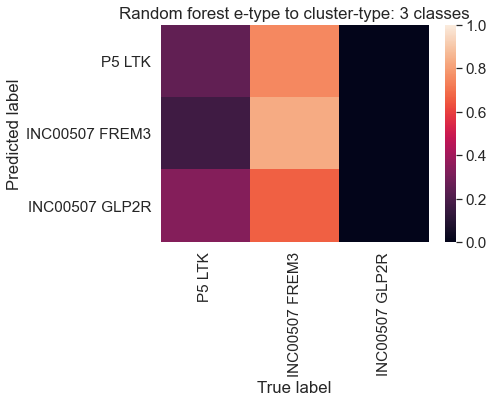

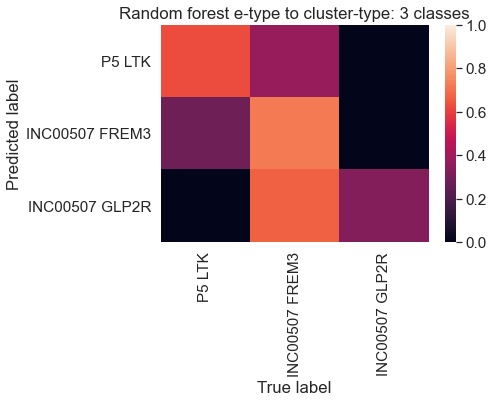

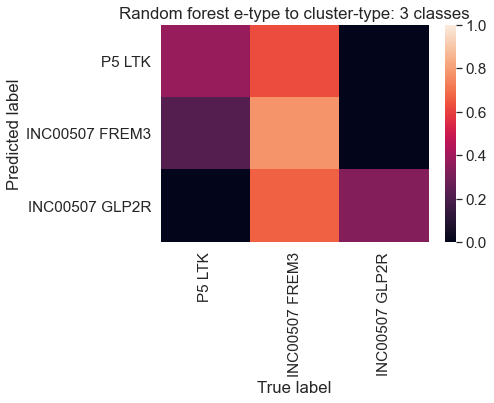

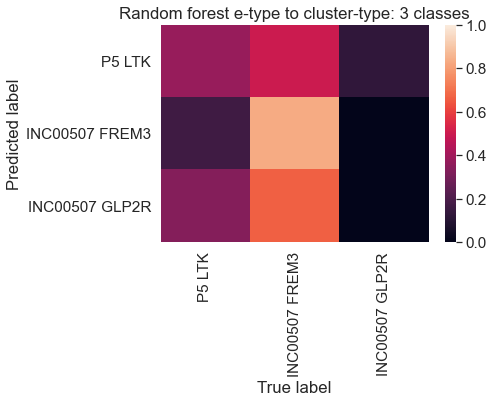

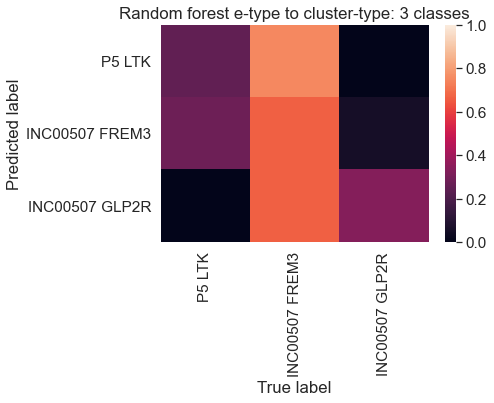

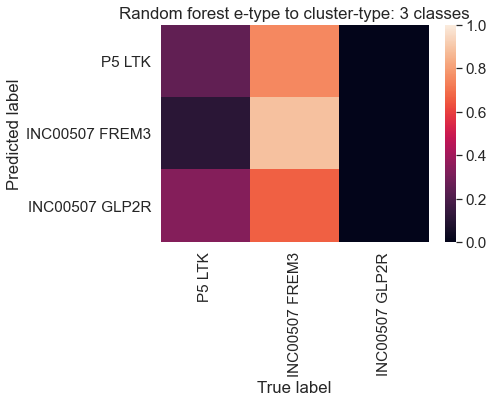

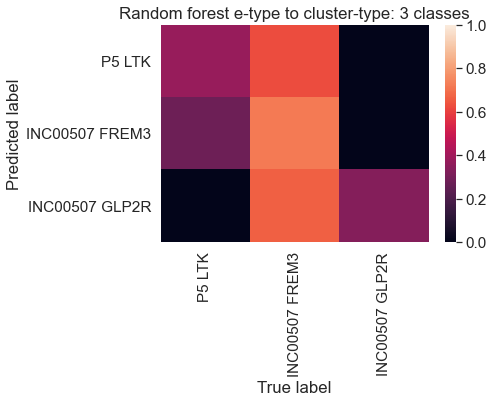

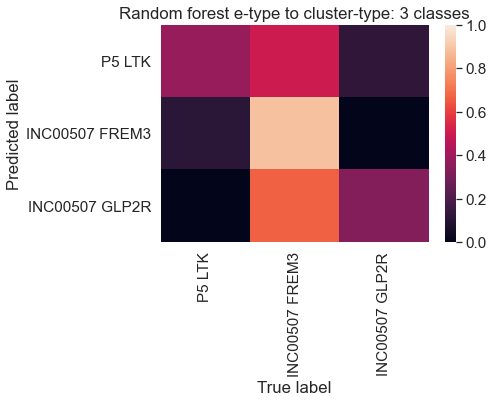

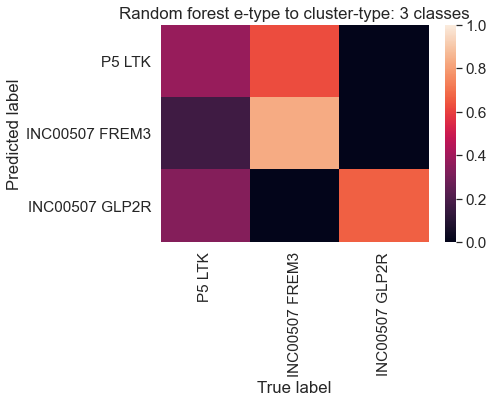

In [24]:

prec_all=[]
rand_all=[]

for j in range(n_repeats):
    prec ,rand = random_forest_plot(human_morpho_array, human_labels, 'Human', feature_list, num_class, use_resampling=False)
    prec_all.append(prec)
    rand_all.append(rand)

print('Classifier precision: ' + str(np.mean(prec_all)))
print('Random precision: ' + str(np.mean(rand_all)))


In [25]:

print('Human morpho')
print('Classifier precision: ' + str(np.mean(prec_all)))
print('Random precision: ' + str(np.mean(rand_all)))


Human morpho
Classifier precision: 0.6379310344827587
Random precision: 0.3310344827586207


## Mouse morpho classifier

Random forest precision: 0.6666666666666666
Random forest f1 score: 0.6666666666666666
Random forest random labels performance: 0.3333333333333333



(0.6666666666666666, 0.3333333333333333)

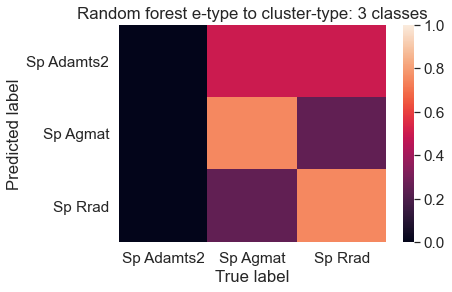

In [26]:

num_class = len(np.unique(mouse_labels))
random_forest_plot(mouse_morpho_array, mouse_labels, 'Mouse', feature_list, num_class, use_resampling=False)
#plt.savefig('Mouse_morpho_3.pdf',format='pdf')


Random forest precision: 0.8333333333333334
Random forest f1 score: 0.8333333333333334
Random forest random labels performance: 0.3333333333333333

Random forest precision: 0.5555555555555556
Random forest f1 score: 0.5555555555555556
Random forest random labels performance: 0.16666666666666666

Random forest precision: 0.6111111111111112
Random forest f1 score: 0.6111111111111112
Random forest random labels performance: 0.2777777777777778

Random forest precision: 0.6666666666666666
Random forest f1 score: 0.6666666666666666
Random forest random labels performance: 0.16666666666666666

Random forest precision: 0.5555555555555556
Random forest f1 score: 0.5555555555555556
Random forest random labels performance: 0.2777777777777778

Random forest precision: 0.6111111111111112
Random forest f1 score: 0.6111111111111112
Random forest random labels performance: 0.2777777777777778

Random forest precision: 0.5555555555555556
Random forest f1 score: 0.5555555555555556
Random forest random la

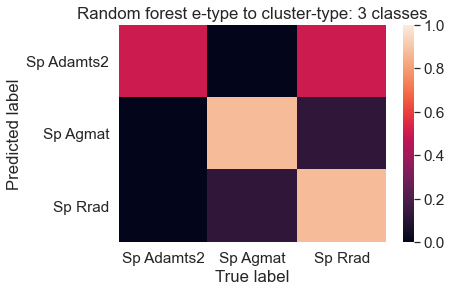

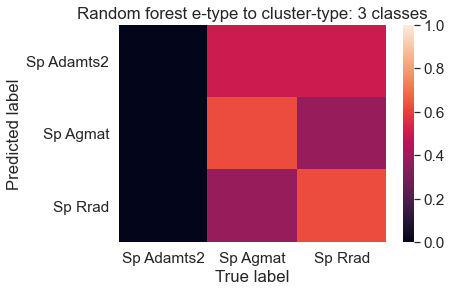

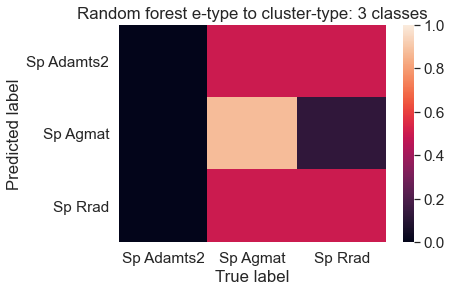

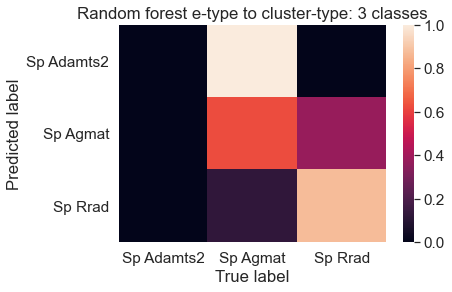

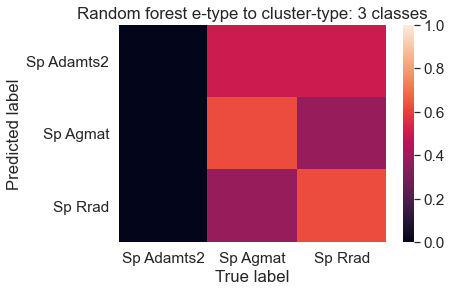

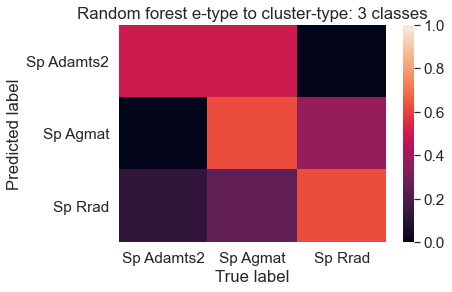

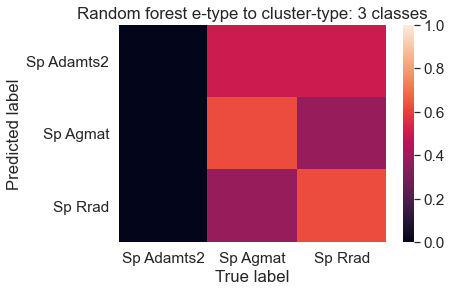

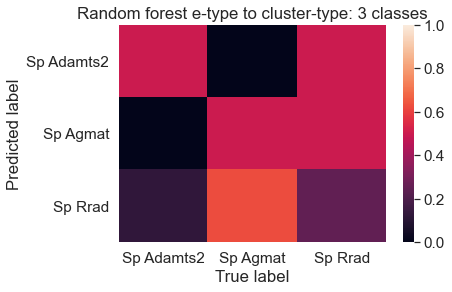

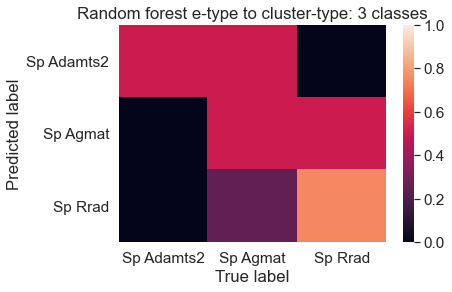

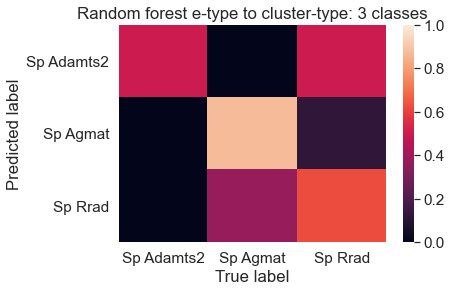

In [27]:
prec_all=[]
rand_all=[]

for j in range(n_repeats):
    prec ,rand = random_forest_plot(mouse_morpho_array, mouse_labels, 'Mouse', feature_list, num_class, use_resampling=False)
    prec_all.append(prec)
    rand_all.append(rand)

print('Classifier precision: ' + str(np.mean(prec_all)))
print('Random precision: ' + str(np.mean(rand_all)))


In [28]:

print('Mouse morpho')
print('Classifier precision: ' + str(np.mean(prec_all)))
print('Random precision: ' + str(np.mean(rand_all)))


Mouse morpho
Classifier precision: 0.6111111111111112
Random precision: 0.2666666666666667


## Human morpho-electric features

### Data preparation

In [29]:

# mouse cell IDs
human_ids = data_human['SpecimenID'].values

# get same cell ids
human_morpho_ephys_id=np.intersect1d(ephys_human['specimen_id'].values,human_morpho['specimen_id'].values)

# extract the same dataframe
df1=ephys_human.loc[ephys_human['specimen_id'].isin(human_morpho_ephys_id)]
df1=df1.sort_values(by='specimen_id')
df2=human_morpho.loc[human_morpho['specimen_id'].isin(human_morpho_ephys_id)]
df2=df2.sort_values(by='specimen_id')

# feature names
a=df1.keys().values[1:]
b=df2.keys().values[1:]
feature_list = np.concatenate((a,b))

# morpho-electric matrix
human_morpho_ephys=np.concatenate((df1.values[:,1:],df2.values[:,1:]),axis=1)

# morpho-electric labels
human_morpho_ephys_labels=data_human.loc[data_human['SpecimenID'].isin(human_morpho_ephys_id)]['SeuratMapping'].values


### Run the classifier on ephys only (control for human)

Random forest precision: 0.7727272727272727
Random forest f1 score: 0.7727272727272727
Random forest random labels performance: 0.3181818181818182

Random forest precision: 0.7272727272727273
Random forest f1 score: 0.7272727272727273
Random forest random labels performance: 0.3181818181818182

Random forest precision: 0.7272727272727273
Random forest f1 score: 0.7272727272727273
Random forest random labels performance: 0.5909090909090909

Random forest precision: 0.7727272727272727
Random forest f1 score: 0.7727272727272727
Random forest random labels performance: 0.36363636363636365

Random forest precision: 0.7272727272727273
Random forest f1 score: 0.7272727272727273
Random forest random labels performance: 0.36363636363636365

Random forest precision: 0.5
Random forest f1 score: 0.5
Random forest random labels performance: 0.2727272727272727

Random forest precision: 0.6363636363636364
Random forest f1 score: 0.6363636363636364
Random forest random labels performance: 0.3181818181

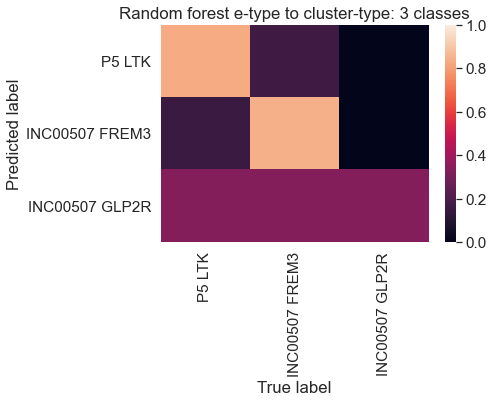

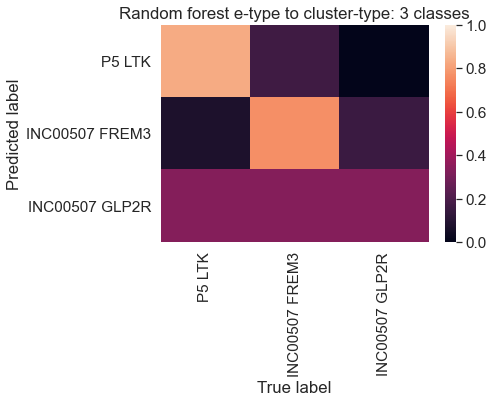

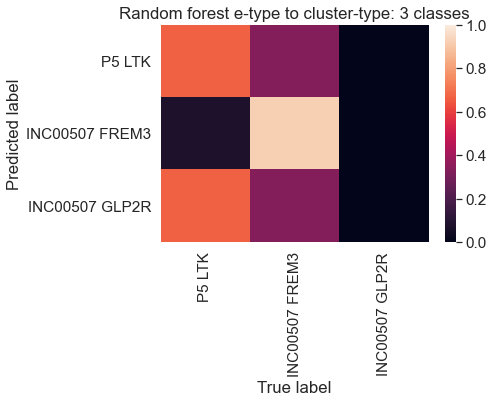

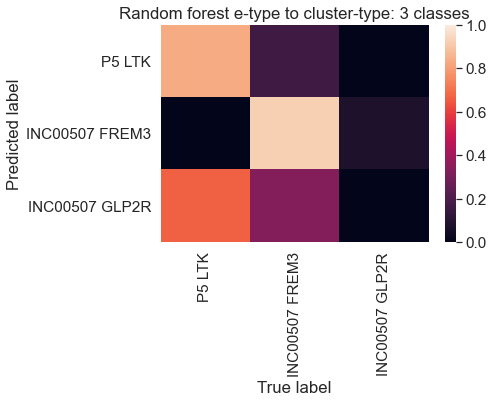

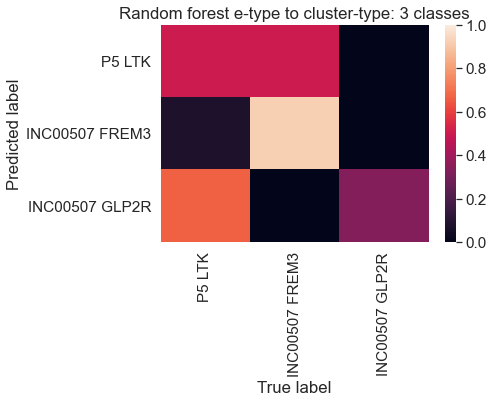

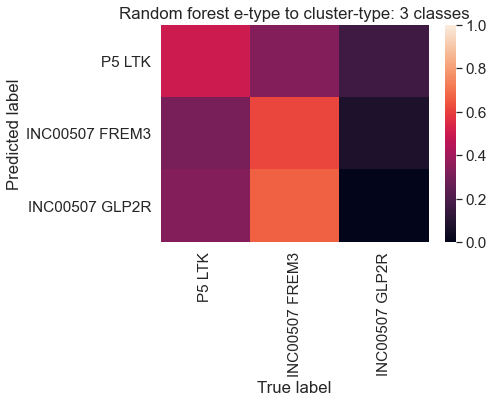

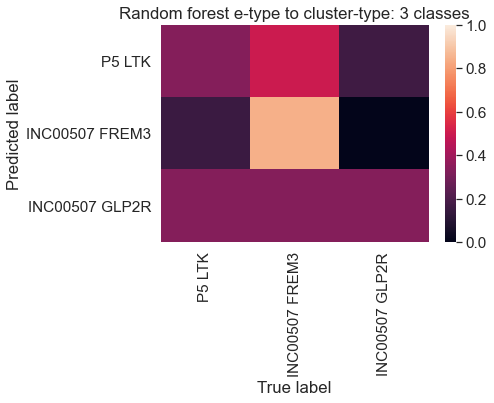

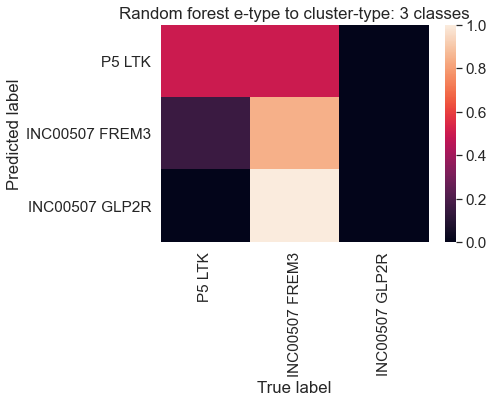

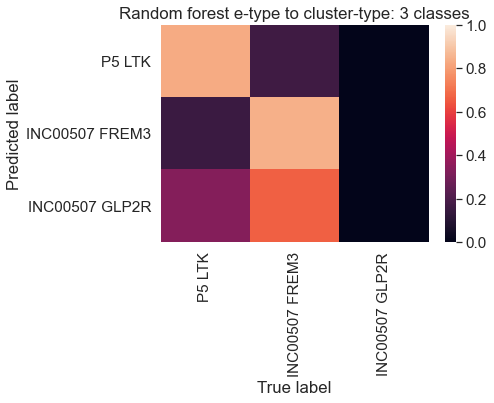

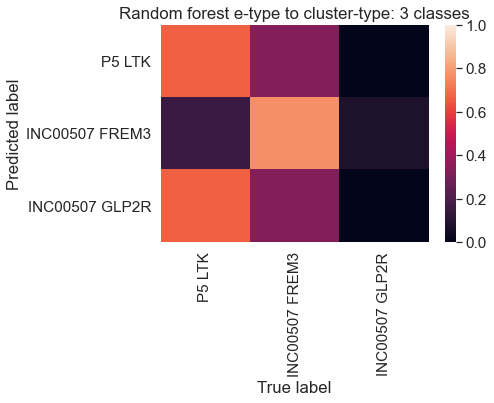

In [30]:

prec_all=[]
rand_all=[]

for j in range(n_repeats):
    prec ,rand = random_forest_plot(df1.values[:,1:], human_morpho_ephys_labels, 'Human', feature_list, num_class, use_resampling=False)
    prec_all.append(prec)
    rand_all.append(rand)


In [31]:

print('Classifier precision: ' + str(np.mean(prec_all)))
print('Random precision: ' + str(np.mean(rand_all)))


Classifier precision: 0.6863636363636364
Random precision: 0.3772727272727273


### Run the classifier on morpho only (human)

Random forest precision: 0.7272727272727273
Random forest f1 score: 0.7272727272727273
Random forest random labels performance: 0.22727272727272727

Random forest precision: 0.7727272727272727
Random forest f1 score: 0.7727272727272727
Random forest random labels performance: 0.2727272727272727

Random forest precision: 0.5909090909090909
Random forest f1 score: 0.5909090909090909
Random forest random labels performance: 0.36363636363636365

Random forest precision: 0.6363636363636364
Random forest f1 score: 0.6363636363636364
Random forest random labels performance: 0.45454545454545453

Random forest precision: 0.6818181818181818
Random forest f1 score: 0.6818181818181818
Random forest random labels performance: 0.22727272727272727

Random forest precision: 0.5454545454545454
Random forest f1 score: 0.5454545454545454
Random forest random labels performance: 0.3181818181818182

Random forest precision: 0.7272727272727273
Random forest f1 score: 0.7272727272727273
Random forest random 

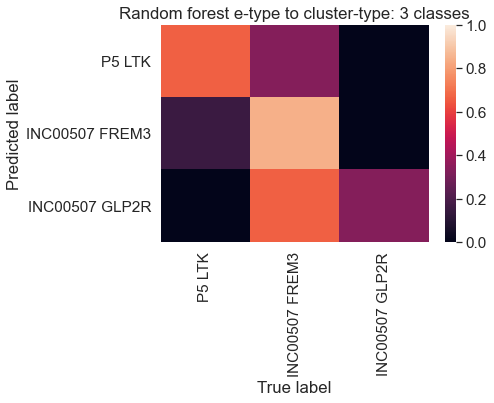

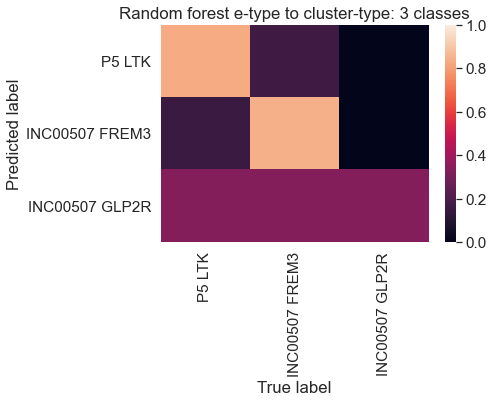

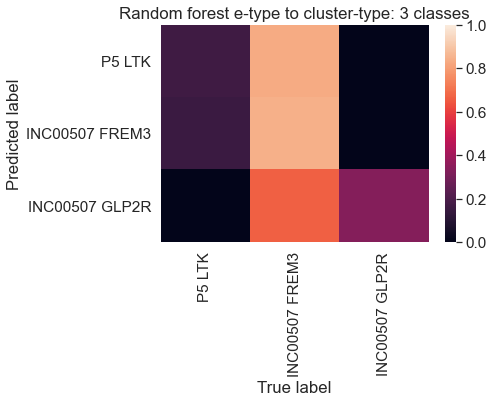

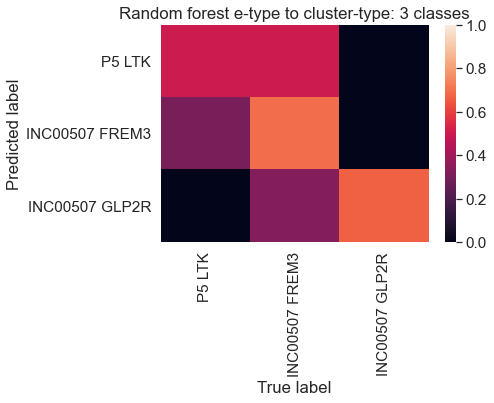

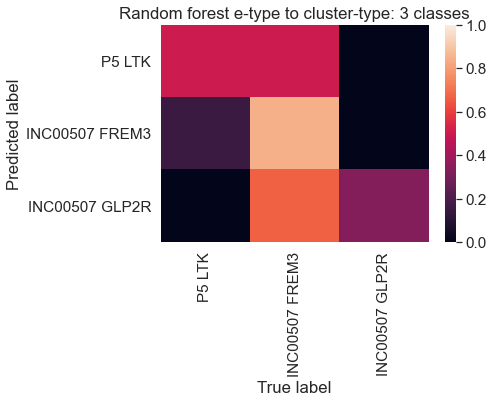

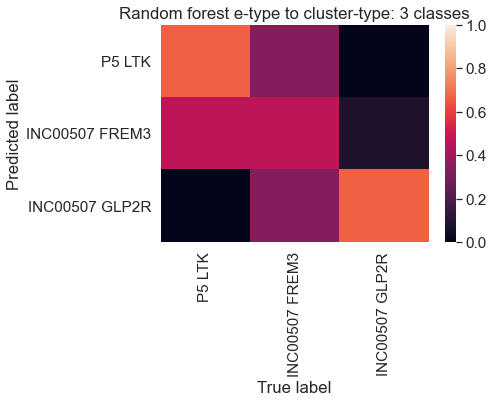

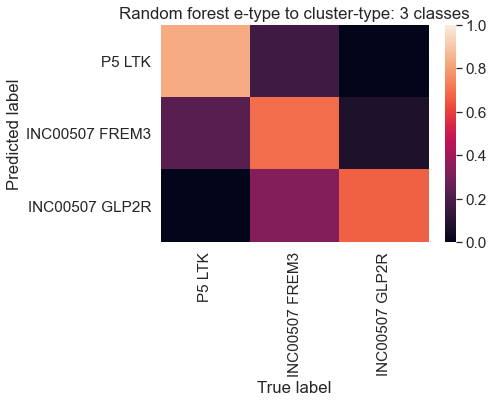

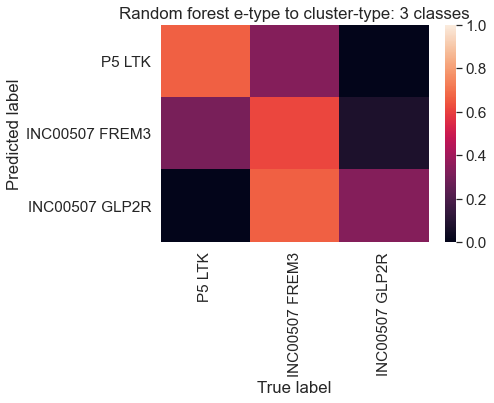

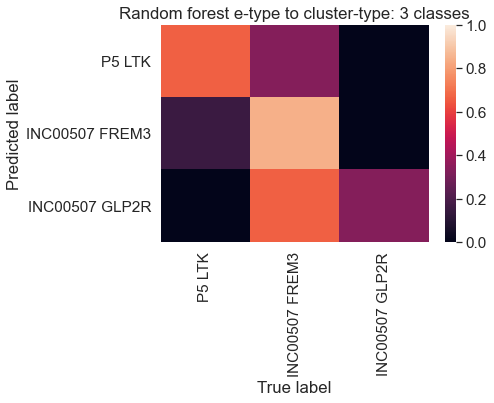

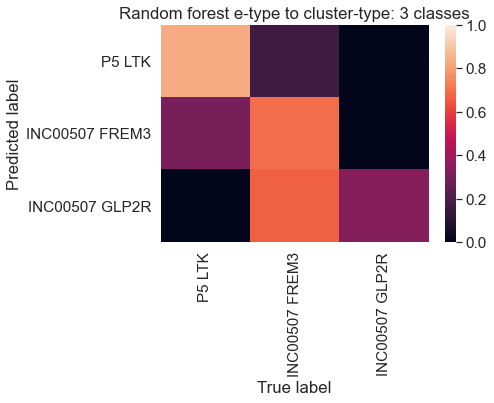

In [32]:

prec_all=[]
rand_all=[]

for j in range(n_repeats):
    prec ,rand = random_forest_plot(df2.values[:,1:], human_morpho_ephys_labels, 'Human', feature_list, num_class, use_resampling=False)
    prec_all.append(prec)
    rand_all.append(rand)


In [33]:

print('Classifier precision: ' + str(np.mean(prec_all)))
print('Random precision: ' + str(np.mean(rand_all)))


Classifier precision: 0.6681818181818182
Random precision: 0.35909090909090907


### Run the classifier on morpho-electro

Random forest precision: 0.7727272727272727
Random forest f1 score: 0.7727272727272727
Random forest random labels performance: 0.4090909090909091



(0.7727272727272727, 0.4090909090909091)

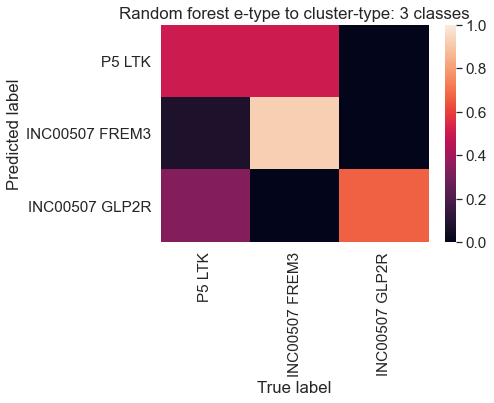

In [34]:

random_forest_plot(human_morpho_ephys, human_morpho_ephys_labels, 'Human', feature_list, num_class, use_resampling=False)
#plt.savefig('Human_morpho_electro_3.pdf',format='pdf')


Random forest precision: 0.6363636363636364
Random forest f1 score: 0.6363636363636364
Random forest random labels performance: 0.3181818181818182

Random forest precision: 0.6818181818181818
Random forest f1 score: 0.6818181818181818
Random forest random labels performance: 0.4090909090909091

Random forest precision: 0.6818181818181818
Random forest f1 score: 0.6818181818181818
Random forest random labels performance: 0.18181818181818182

Random forest precision: 0.6818181818181818
Random forest f1 score: 0.6818181818181818
Random forest random labels performance: 0.2727272727272727

Random forest precision: 0.6818181818181818
Random forest f1 score: 0.6818181818181818
Random forest random labels performance: 0.5909090909090909

Random forest precision: 0.6818181818181818
Random forest f1 score: 0.6818181818181818
Random forest random labels performance: 0.22727272727272727

Random forest precision: 0.7727272727272727
Random forest f1 score: 0.7727272727272727
Random forest random la

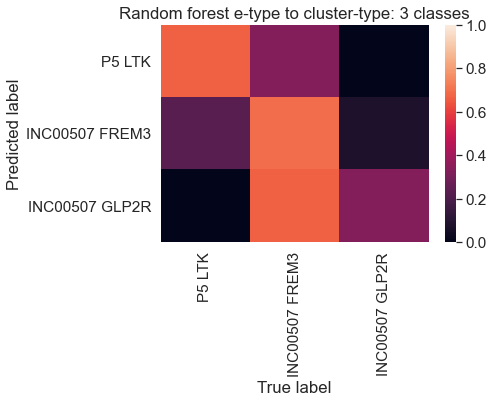

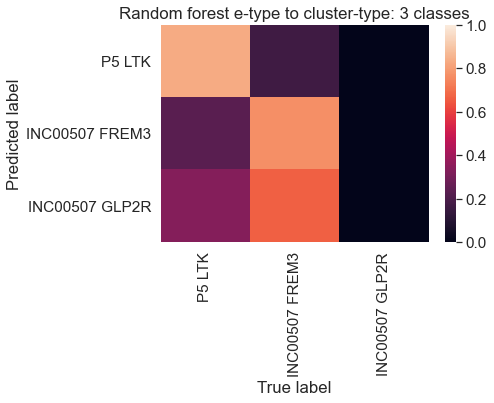

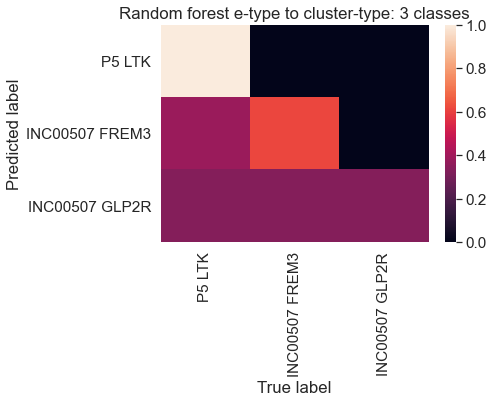

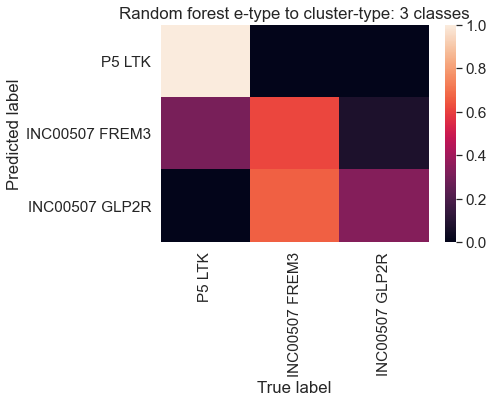

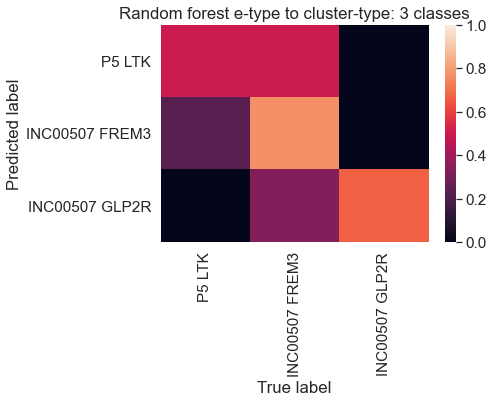

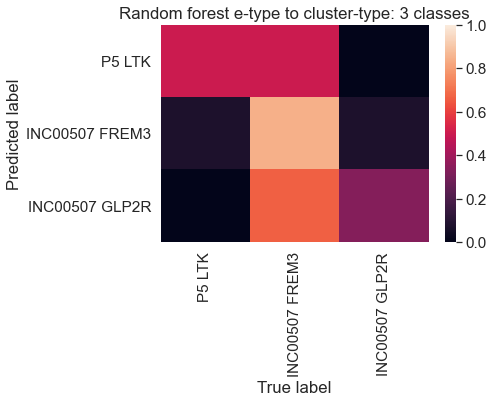

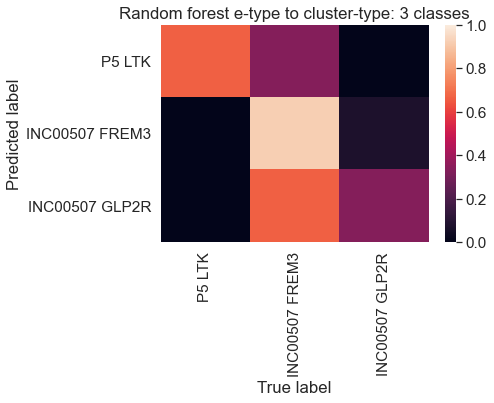

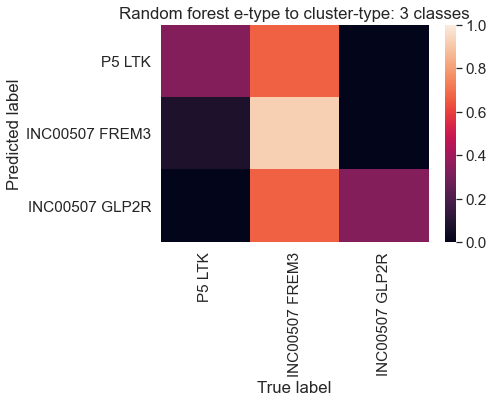

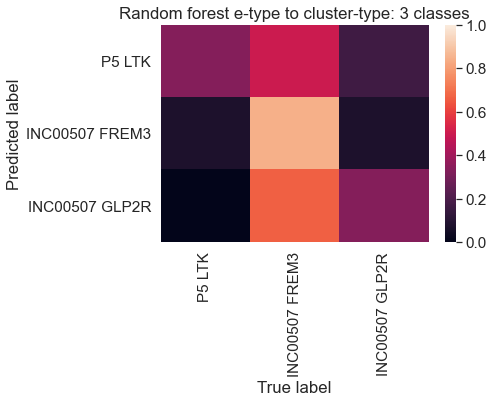

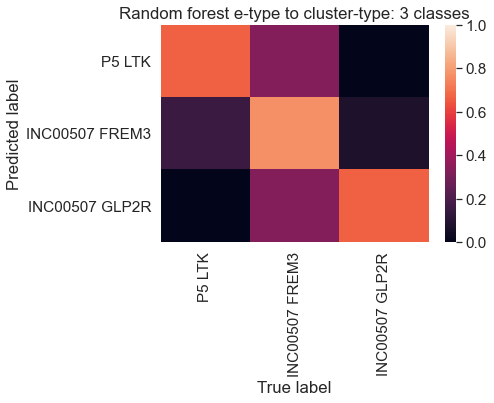

In [35]:

prec_all=[]
rand_all=[]

for j in range(n_repeats):
    prec ,rand = random_forest_plot(human_morpho_ephys, human_morpho_ephys_labels, 'Human', feature_list, num_class, use_resampling=False)
    prec_all.append(prec)
    rand_all.append(rand)


In [36]:

print('Classifier precision: ' + str(np.mean(prec_all)))
print('Random precision: ' + str(np.mean(rand_all)))


Classifier precision: 0.6863636363636364
Random precision: 0.35454545454545455


## Mouse morpho-electric features

### Data preparation

In [37]:

# mouse cell IDs
mouse_ids = data_mouse['SpecimenID'].values

# get same cell ids
mouse_morpho_ephys_id=np.intersect1d(ephys_mouse['specimen_id'].values,mouse_morpho['specimen_id'].values)

# extract the same dataframe
df1=ephys_mouse.loc[ephys_mouse['specimen_id'].isin(mouse_morpho_ephys_id)]
df1=df1.sort_values(by='specimen_id')
df2=mouse_morpho.loc[mouse_morpho['specimen_id'].isin(mouse_morpho_ephys_id)]
df2=df2.sort_values(by='specimen_id')

# feature names
a=df1.keys().values[1:]
b=df2.keys().values[1:]
feature_list = np.concatenate((a,b))

# morpho-electric matrix
mouse_morpho_ephys=np.concatenate((df1.values[:,1:],df2.values[:,1:]),axis=1)

# morpho-electric labels
mouse_morpho_ephys_labels=data_mouse.loc[data_mouse['SpecimenID'].isin(mouse_morpho_ephys_id)]['SeuratMapping'].values


### Run the classifier on ephys only (control for mouse)

Random forest precision: 0.5333333333333333
Random forest f1 score: 0.5333333333333333
Random forest random labels performance: 0.3333333333333333

Random forest precision: 0.5333333333333333
Random forest f1 score: 0.5333333333333333
Random forest random labels performance: 0.26666666666666666

Random forest precision: 0.4
Random forest f1 score: 0.4000000000000001
Random forest random labels performance: 0.3333333333333333

Random forest precision: 0.4666666666666667
Random forest f1 score: 0.4666666666666667
Random forest random labels performance: 0.4666666666666667

Random forest precision: 0.5333333333333333
Random forest f1 score: 0.5333333333333333
Random forest random labels performance: 0.2

Random forest precision: 0.6
Random forest f1 score: 0.6
Random forest random labels performance: 0.4

Random forest precision: 0.6
Random forest f1 score: 0.6
Random forest random labels performance: 0.3333333333333333

Random forest precision: 0.4
Random forest f1 score: 0.4000000000000

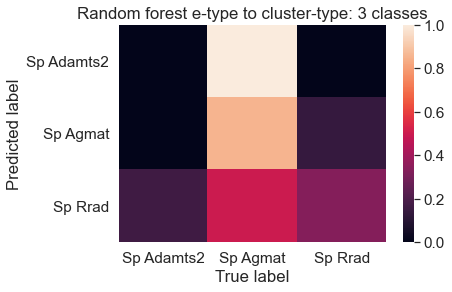

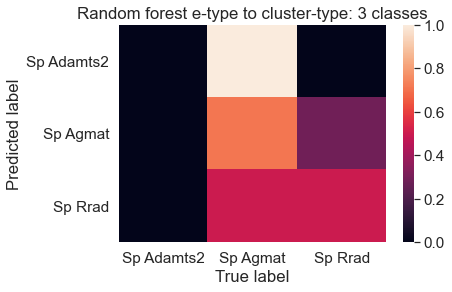

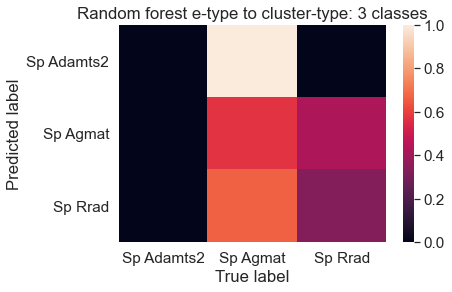

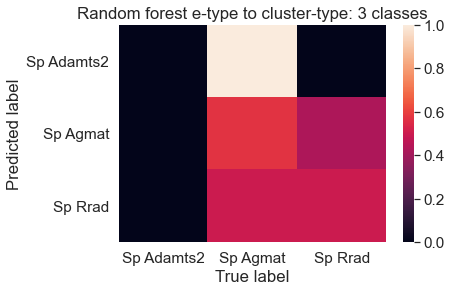

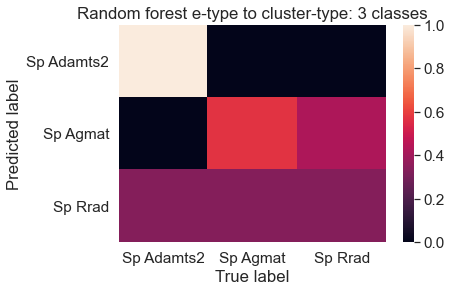

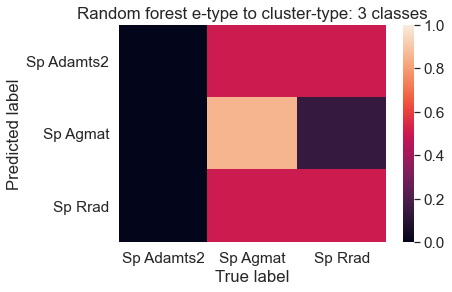

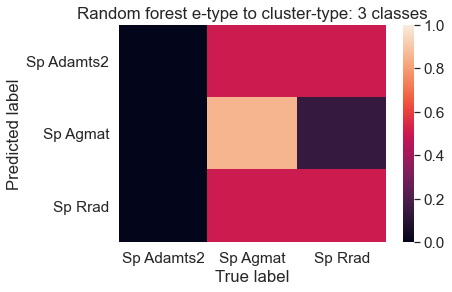

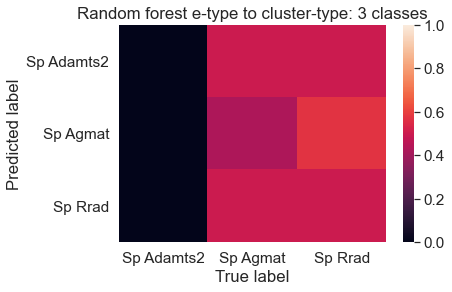

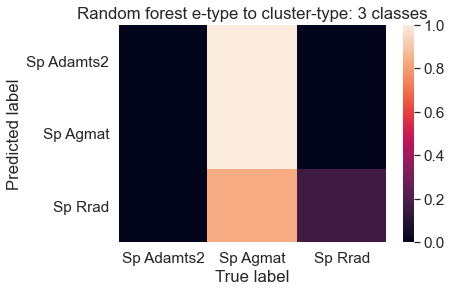

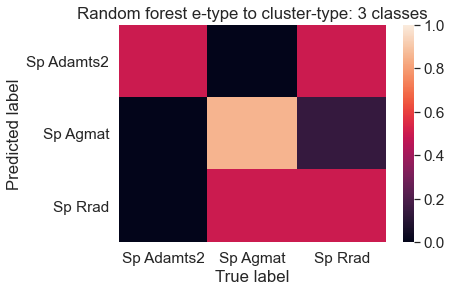

In [38]:

prec_all=[]
rand_all=[]

for j in range(n_repeats):
    prec ,rand = random_forest_plot(df1.values[:,1:], mouse_morpho_ephys_labels, 'Mouse', feature_list, num_class, use_resampling=False)
    prec_all.append(prec)
    rand_all.append(rand)


In [39]:

print('Classifier precision: ' + str(np.mean(prec_all)))
print('Random precision: ' + str(np.mean(rand_all)))


Classifier precision: 0.5266666666666666
Random precision: 0.33333333333333337


### Run the classifier on morpho only (control for mouse)

Random forest precision: 0.6
Random forest f1 score: 0.6
Random forest random labels performance: 0.4

Random forest precision: 0.5333333333333333
Random forest f1 score: 0.5333333333333333
Random forest random labels performance: 0.26666666666666666

Random forest precision: 0.5333333333333333
Random forest f1 score: 0.5333333333333333
Random forest random labels performance: 0.2

Random forest precision: 0.5333333333333333
Random forest f1 score: 0.5333333333333333
Random forest random labels performance: 0.4666666666666667

Random forest precision: 0.5333333333333333
Random forest f1 score: 0.5333333333333333
Random forest random labels performance: 0.4

Random forest precision: 0.3333333333333333
Random forest f1 score: 0.3333333333333333
Random forest random labels performance: 0.4666666666666667

Random forest precision: 0.5333333333333333
Random forest f1 score: 0.5333333333333333
Random forest random labels performance: 0.2

Random forest precision: 0.4
Random forest f1 score: 

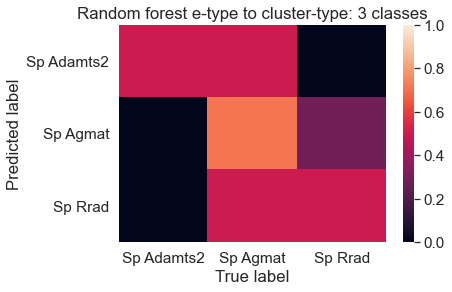

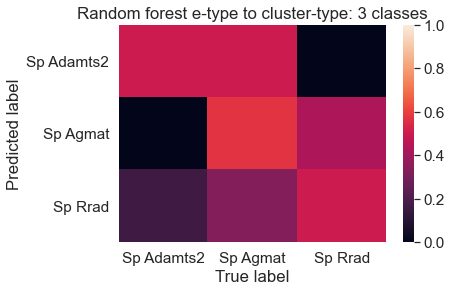

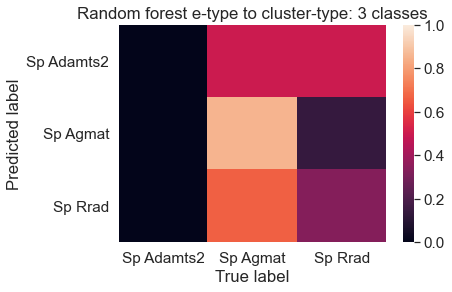

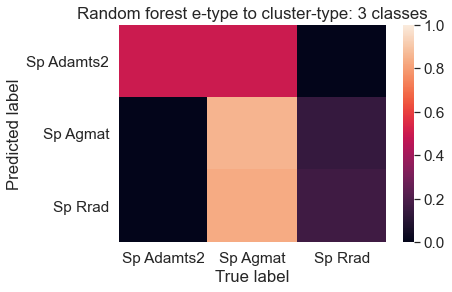

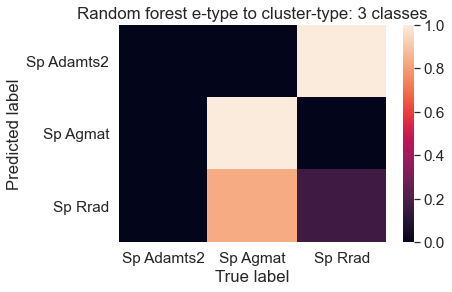

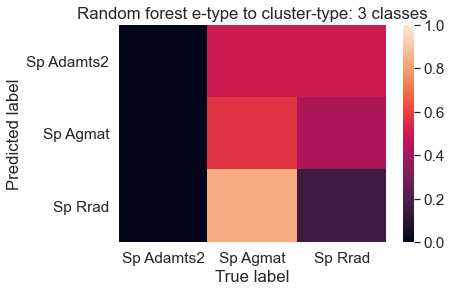

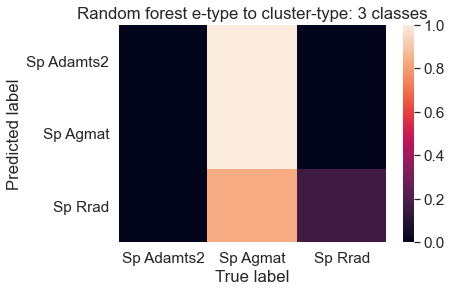

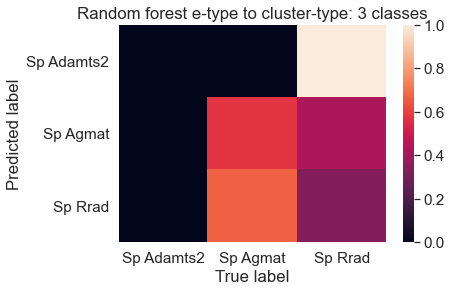

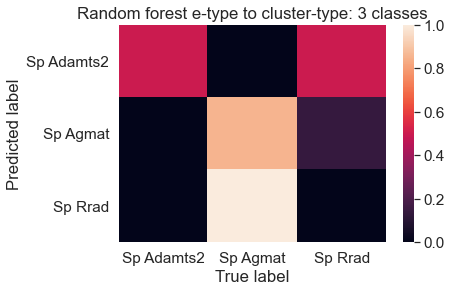

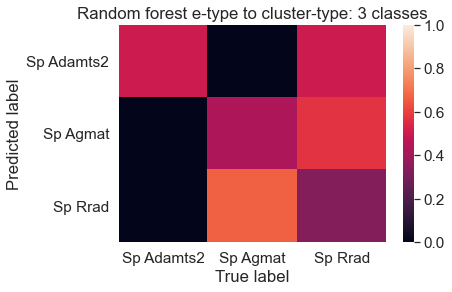

In [40]:

prec_all=[]
rand_all=[]

for j in range(n_repeats):
    prec ,rand = random_forest_plot(df2.values[:,1:], mouse_morpho_ephys_labels, 'Mouse', feature_list, num_class, use_resampling=False)
    prec_all.append(prec)
    rand_all.append(rand)


In [41]:

print('Classifier precision: ' + str(np.mean(prec_all)))
print('Random precision: ' + str(np.mean(rand_all)))


Classifier precision: 0.4866666666666667
Random precision: 0.3266666666666667


### Run the classifier on morpho-ephys of mouse

Random forest precision: 0.6666666666666666
Random forest f1 score: 0.6666666666666666
Random forest random labels performance: 0.3333333333333333



(0.6666666666666666, 0.3333333333333333)

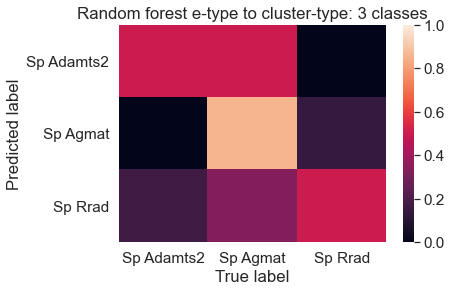

In [42]:

random_forest_plot(mouse_morpho_ephys, mouse_morpho_ephys_labels, 'Mouse', feature_list, num_class, use_resampling=False)
#plt.savefig('Mouse_morpho_electro_3.pdf',format='pdf')


Random forest precision: 0.6666666666666666
Random forest f1 score: 0.6666666666666666
Random forest random labels performance: 0.3333333333333333

Random forest precision: 0.5333333333333333
Random forest f1 score: 0.5333333333333333
Random forest random labels performance: 0.4

Random forest precision: 0.7333333333333333
Random forest f1 score: 0.7333333333333333
Random forest random labels performance: 0.13333333333333333

Random forest precision: 0.6666666666666666
Random forest f1 score: 0.6666666666666666
Random forest random labels performance: 0.26666666666666666

Random forest precision: 0.5333333333333333
Random forest f1 score: 0.5333333333333333
Random forest random labels performance: 0.2

Random forest precision: 0.7333333333333333
Random forest f1 score: 0.7333333333333333
Random forest random labels performance: 0.13333333333333333

Random forest precision: 0.6666666666666666
Random forest f1 score: 0.6666666666666666
Random forest random labels performance: 0.066666666

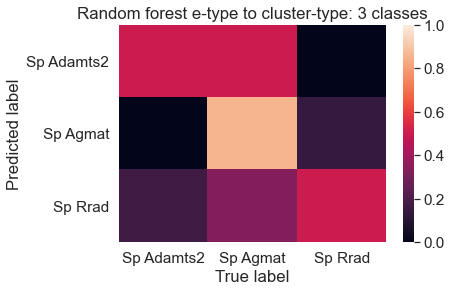

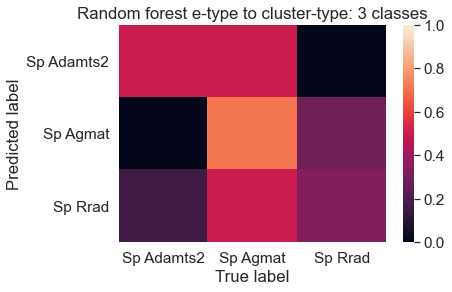

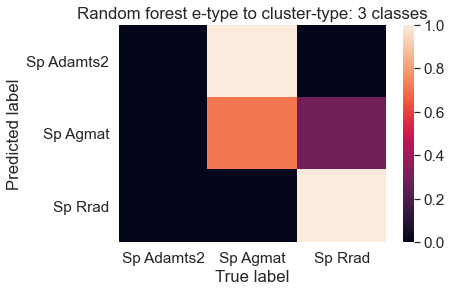

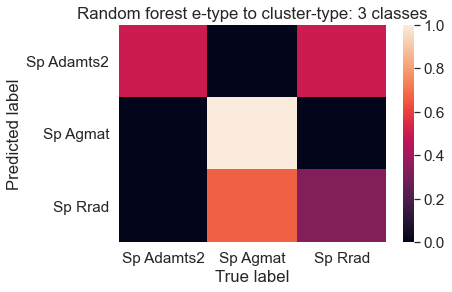

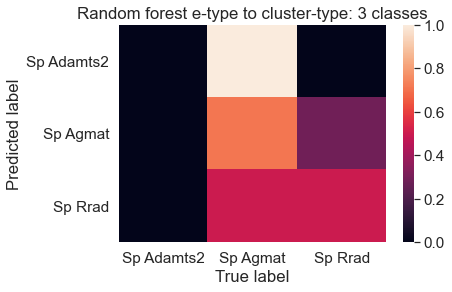

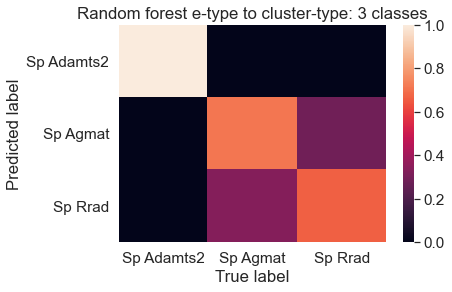

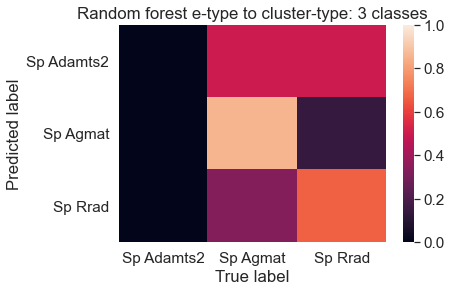

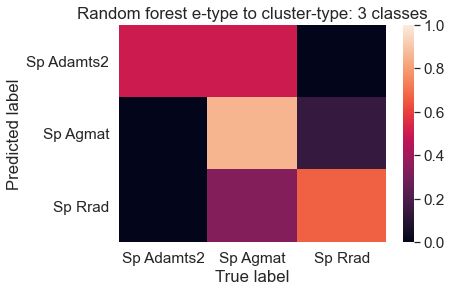

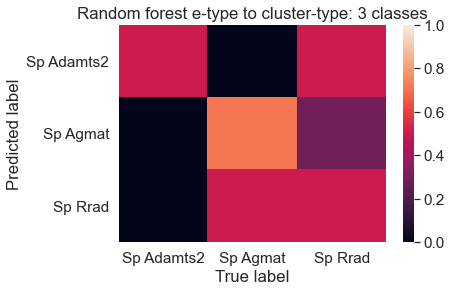

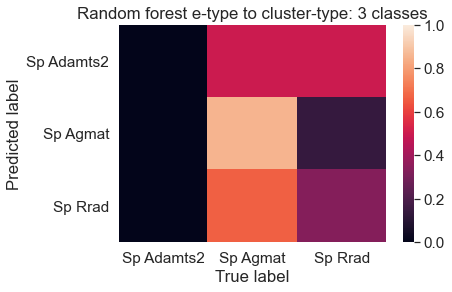

In [43]:

prec_all=[]
rand_all=[]

for j in range(n_repeats):
    prec ,rand = random_forest_plot(mouse_morpho_ephys, mouse_morpho_ephys_labels, 'Mouse', feature_list, num_class, use_resampling=False)
    prec_all.append(prec)
    rand_all.append(rand)


In [44]:

print('Classifier precision: ' + str(np.mean(prec_all)))
print('Random precision: ' + str(np.mean(rand_all)))


Classifier precision: 0.6399999999999999
Random precision: 0.3
